Funds Rate dataset from [FRED Economic](https://fred.stlouisfed.org/series/FEDFUNDS) Data website. 

In [96]:
import warnings       
import numpy as np   
import pandas as pd
from pandas import Grouper
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt    
import seaborn as sns
import os
warnings.filterwarnings('ignore')


In [4]:
pwd = os.getcwd()
# df   = pd.read_csv(os.path.basename(pwd + '/FEDFUNDS.csv'))
df   = pd.read_csv(os.path.basename(pwd + '/FEDFUNDS.csv'),
                        index_col='DATE',
                        dtype={'FEDFUNDS': np.float32},
                        parse_dates=True, 
                        date_parser=lambda date: pd.datetime.strptime(date, '%Y-%m-%d'),
                       )


df.head(5)

,FEDFUNDS
DATE,
1954-07-01,0.80
1954-08-01,1.22
1954-09-01,1.07
1954-10-01,0.85
1954-11-01,0.83


In [5]:
df.unstack().head()

          DATE      
FEDFUNDS  1954-07-01    0.80
          1954-08-01    1.22
          1954-09-01    1.07
          1954-10-01    0.85
          1954-11-01    0.83
dtype: float32

In [6]:
# df.head().values

In [7]:
# df.unstack().head().values

In [8]:
# create a time series
s = pd.Series(df.unstack().values, index=df.index)

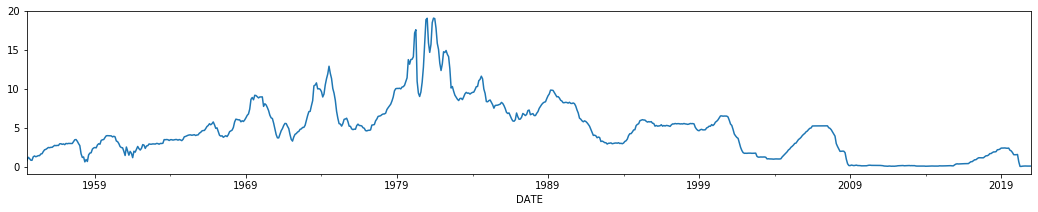

In [9]:
plt.rc('figure', figsize=(18, 3))
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.display.max_rows = 20
s.plot()

In [10]:
s[:'2007'].tail(10)

DATE
2007-03-01   5.26
2007-04-01   5.25
2007-05-01   5.25
2007-06-01   5.25
2007-07-01   5.26
2007-08-01   5.02
2007-09-01   4.94
2007-10-01   4.76
2007-11-01   4.49
2007-12-01   4.24
dtype: float32

In [11]:


# keep only data before 2008 
s = s[:'2007']
s.head()


DATE
1954-07-01   0.80
1954-08-01   1.22
1954-09-01   1.07
1954-10-01   0.85
1954-11-01   0.83
dtype: float32

In [12]:
# calculate descriptive statistics
s.describe()

count   642.00
mean      5.69
std       3.32
min       0.63
25%       3.30
50%       5.25
75%       7.30
max      19.10
dtype: float64

In [13]:
# query a dataset using a date-time index
s['1999-06':'2000-06']


DATE
1999-06-01   4.76
1999-07-01   4.99
1999-08-01   5.07
1999-09-01   5.22
1999-10-01   5.20
1999-11-01   5.42
1999-12-01   5.30
2000-01-01   5.45
2000-02-01   5.73
2000-03-01   5.85
2000-04-01   6.02
2000-05-01   6.27
2000-06-01   6.53
dtype: float32

In [14]:

df1 = pd.DataFrame()
df1['year'] =  [s.index[i].year for i in range(len(s))]
df1['month'] = [s.index[i].month for i in range(len(s))]
df1['value'] = s.values.tolist()


In [15]:

df1.head()


,year,month,value
0,1954,7,0.80
1,1954,8,1.22
2,1954,9,1.07
3,1954,10,0.85
4,1954,11,0.83


In [16]:
values = pd.DataFrame(s.values)
df1 = pd.concat([values.shift(1), values], axis=1)
df1.columns = ['t', 't+1']

In [17]:
df1.head()

,t,t+1
0,NaN,0.80
1,0.80,1.22
2,1.22,1.07
3,1.07,0.85
4,0.85,0.83


In [18]:
df1.tail()

,t,t+1
637,5.26,5.02
638,5.02,4.94
639,4.94,4.76
640,4.76,4.49
641,4.49,4.24


###  Window feature

In [19]:
values = pd.DataFrame(s.values)
df1 = pd.concat([values.shift(3), values.shift(2), values.shift(1), values], axis=1)
df1.columns = ['t-2', 't-1', 't', 't+1']

In [20]:
df1.head()

,t-2,t-1,t,t+1
0,NaN,NaN,NaN,0.80
1,NaN,NaN,0.80,1.22
2,NaN,0.80,1.22,1.07
3,0.80,1.22,1.07,0.85
4,1.22,1.07,0.85,0.83


In [21]:
df1.tail()

,t-2,t-1,t,t+1
637,5.25,5.25,5.26,5.02
638,5.25,5.26,5.02,4.94
639,5.26,5.02,4.94,4.76
640,5.02,4.94,4.76,4.49
641,4.94,4.76,4.49,4.24


In [41]:
#Rolling Window Statistics (Add a summary of the values at previous time steps)
values = pd.DataFrame(s.values)
shifted = values.shift(1)
window = shifted.rolling(window=2)
means = window.mean()

df1 = pd.concat([means, values], axis=1)
df1.columns = ['mean(t-1,t)', 't+1']

In [42]:
df1.head()

,"mean(t-1,t)",t+1
0,NaN,0.80
1,NaN,1.22
2,1.01,1.07
3,1.15,0.85
4,0.96,0.83


In [43]:
df1.tail()

,"mean(t-1,t)",t+1
637,5.26,5.02
638,5.14,4.94
639,4.98,4.76
640,4.85,4.49
641,4.62,4.24


In [44]:
values = pd.DataFrame(s.values)
width = 3
shifted = values.shift(width - 1)
window = shifted.rolling(window=width)

df1 = pd.concat([window.min(), window.mean(), window.max(), values], axis=1)
df1.columns = ['min', 'mean', 'max', 't+1']

In [45]:
df1.head()

,min,mean,max,t+1
0,NaN,NaN,NaN,0.80
1,NaN,NaN,NaN,1.22
2,NaN,NaN,NaN,1.07
3,NaN,NaN,NaN,0.85
4,0.80,1.03,1.22,0.83


In [46]:
df1.tail()

,min,mean,max,t+1
637,5.25,5.25,5.25,5.02
638,5.25,5.25,5.26,4.94
639,5.02,5.18,5.26,4.76
640,4.94,5.07,5.26,4.49
641,4.76,4.91,5.02,4.24


In [55]:
#Expanding Window Statistics
values = pd.DataFrame(s.values)
window = values.expanding()

df1 = pd.concat([window.min(), window.mean(), window.max(), values], axis=1)
df1.columns = ['min', 'mean', 'max', 't+1']

In [56]:
df1.head()

,min,mean,max,t+1
0,0.80,0.80,0.80,0.80
1,0.80,1.01,1.22,1.22
2,0.80,1.03,1.22,1.07
3,0.80,0.99,1.22,0.85
4,0.80,0.95,1.22,0.83


In [57]:
df1.tail()

,min,mean,max,t+1
637,0.63,5.70,19.10,5.02
638,0.63,5.70,19.10,4.94
639,0.63,5.69,19.10,4.76
640,0.63,5.69,19.10,4.49
641,0.63,5.69,19.10,4.24


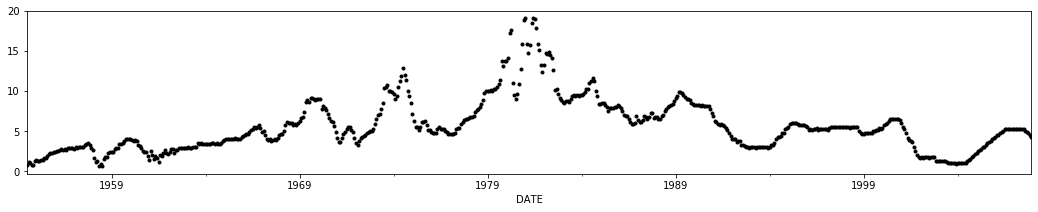

In [58]:
# Data Visualization
s.plot(style='k.')

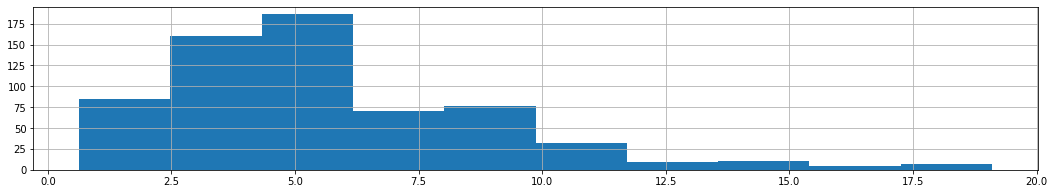

In [59]:
s.hist()

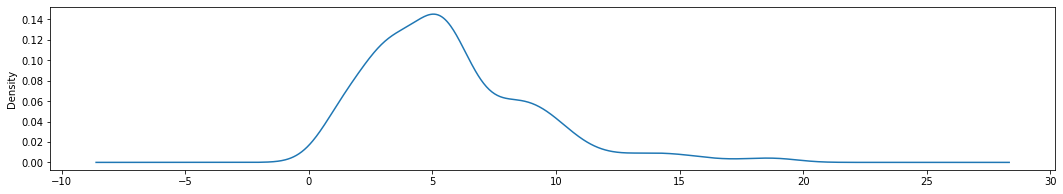

In [60]:
s.plot(kind='kde')

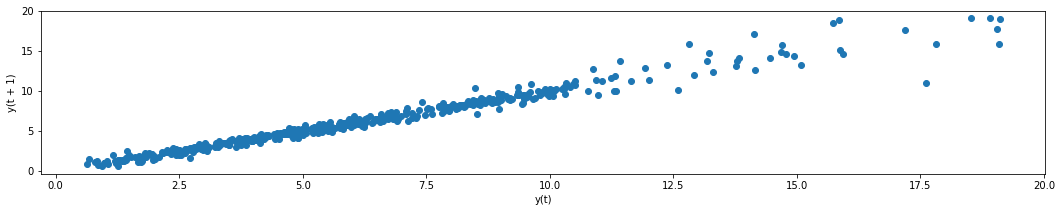

In [67]:
# create a scatter plot
lag_plot(s)

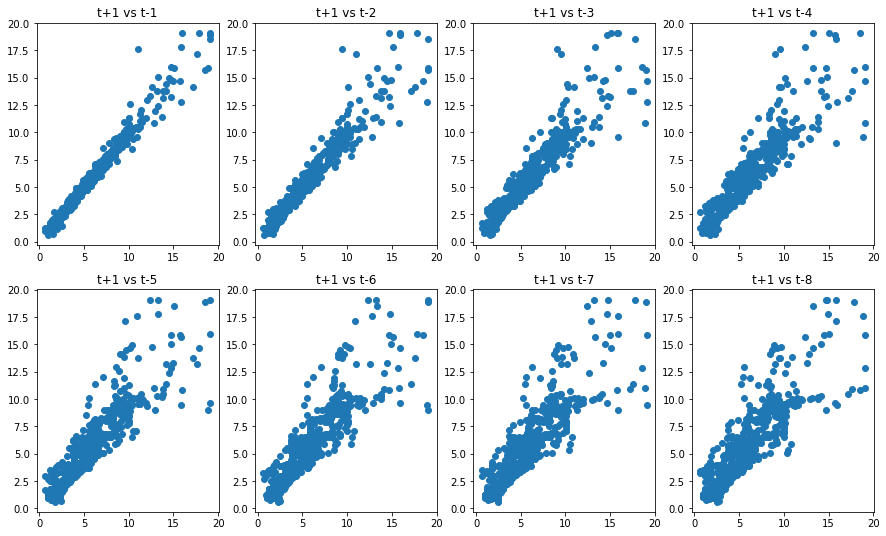

In [71]:
# create multiple scatter plots
values = pd.DataFrame(s.values)
lags = 8
columns = [values]

for i in range(1,(lags + 1)):
    columns.append(values.shift(i))

df1 = pd.concat(columns, axis=1)
columns = ['t+1']

for i in range(1,(lags + 1)):
    columns.append('t-' + str(i))
df1.columns = columns

plt.figure(1, figsize=(15,9))
for i in range(1,(lags + 1)):
    ax = plt.subplot(240 + i)
    ax.set_title('t+1 vs t-' + str(i))
    plt.scatter(x=df1['t+1'].values, y=df1['t-'+str(i)].values)

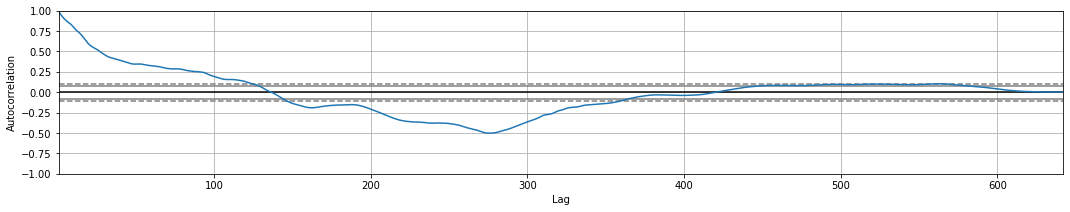

In [74]:
# create an autocorrelation plot
autocorrelation_plot(s)

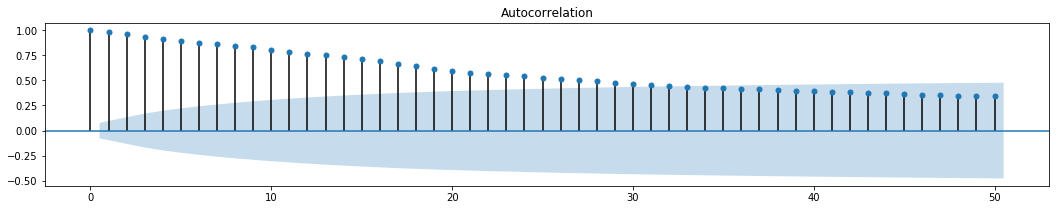

In [77]:
# autocorrelation plot of time series as a line plot
plot_acf(s, lags=50)
plt.show()

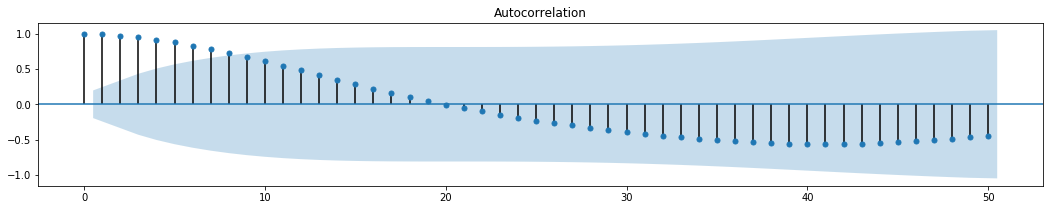

In [78]:
# autocorrelation plot of time series as a line plot
plot_acf(s[-100:], lags=50)
plt.show()

In [79]:
# tail-rolling average transform
rolling = s.rolling(window=3)
rolling_mean = rolling.mean()

In [80]:
rolling_mean.head(10)


DATE
1954-07-01    NaN
1954-08-01    NaN
1954-09-01   1.03
1954-10-01   1.05
1954-11-01   0.92
1954-12-01   0.99
1955-01-01   1.17
1955-02-01   1.32
1955-03-01   1.34
1955-04-01   1.36
dtype: float64

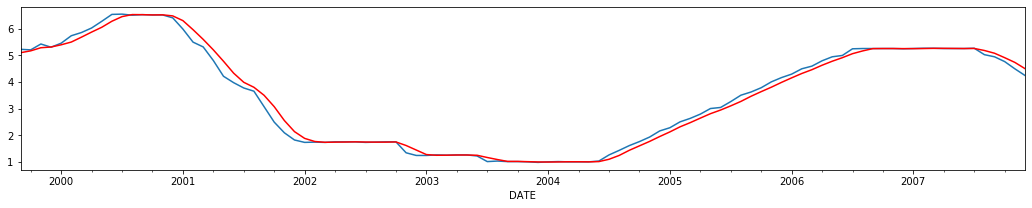

In [81]:
# plot original and transformed dataset
s[-100:].plot()
rolling_mean[-100:].plot(color='red')

In [84]:
# prepare problem
X = s.values
window = 3
history = [X[i] for i in range(window)]
test = [X[i] for i in range(window, len(X))]
predictions = []

# walk forward over time steps in test
for t in range(len(test)):
    length = len(history)
    yhat = np.mean([history[i] for i in range(length-window,length)])
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
rmse = np.sqrt(mean_squared_error(test, predictions))

In [86]:
print('RMSE: %.3f' % rmse)

RMSE: 0.817


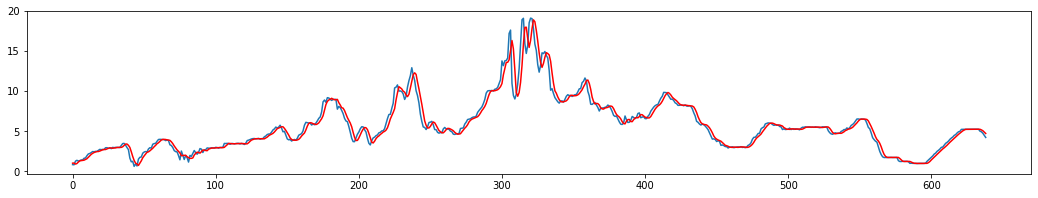

In [87]:
#  plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

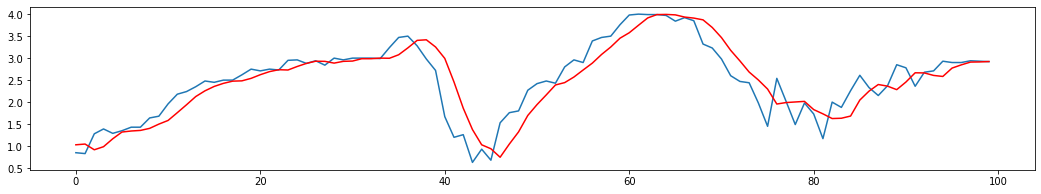

In [88]:
# zoom plot
plt.plot(test[:100])
plt.plot(predictions[:100], color='red')
plt.show()

In [91]:
# calculate stationarity test of time series data
X = s.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.184809
p-value: 0.020881
Critical Values:
	1%: -3.441
	5%: -2.866
	10%: -2.569


In [92]:

# calculate a train-test split of a time series dataset
X = s.values
train_size = int(len(X) * 0.66)
train, test = X[0:train_size], X[train_size:len(X)]

In [93]:
print('Observations: %d' % (len(X)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

Observations: 642
Training Observations: 423
Testing Observations: 219


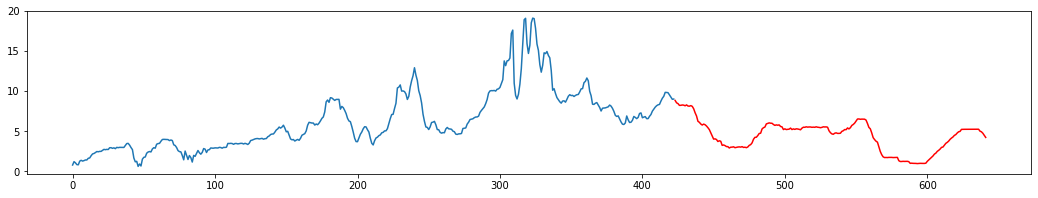

In [94]:
# plot train-test split of time series data
plt.plot(train)
plt.plot([None for i in train] + [x for x in test], color='r')

Observations: 322
Training Observations: 162
Testing Observations: 160
-----
Observations: 482
Training Observations: 322
Testing Observations: 160
-----
Observations: 642
Training Observations: 482
Testing Observations: 160
-----


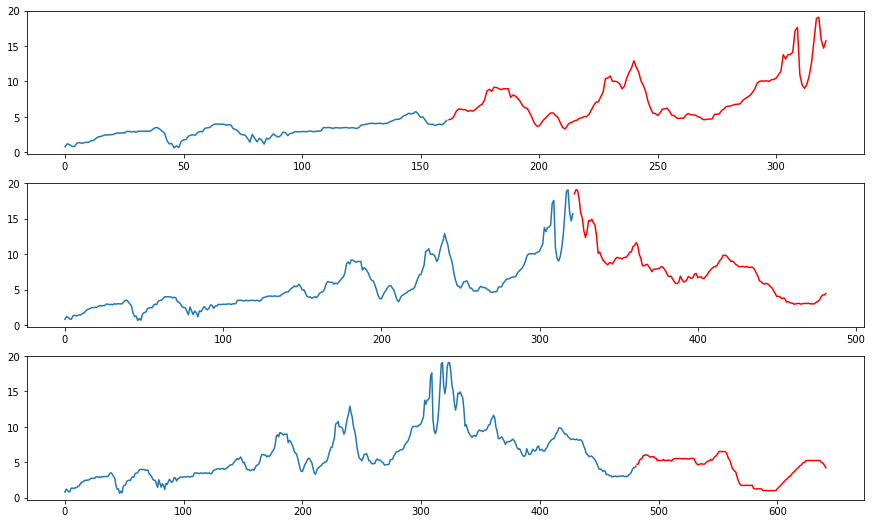

In [97]:
# calculate repeated train-test splits of time series data
X = s.values
splits = TimeSeriesSplit(n_splits=3)
index = 1
plt.figure(1, figsize=(15,9))

for train_index, test_index in splits.split(X):
    train = X[train_index]
    test = X[test_index]

    print('Observations: %d' % (len(train) + len(test)))
    print('Training Observations: %d' % (len(train)))
    print('Testing Observations: %d\n-----' % (len(test)))

    plt.subplot(310 + index)
    plt.plot(train)
    plt.plot([None for i in train] + [x for x in test], color='r')
    index += 1
plt.show()

In [99]:
# Create lagged dataset
values = pd.DataFrame(s.values)
df1 = pd.concat([values.shift(1), values], axis=1)
df1.columns = ['t', 't+1']

In [101]:
# split into train and test sets
X = df1.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]

train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

In [102]:
# persistence model
def model_persistence(x):
    return x

In [103]:
# walk-forward validation
predictions = []
for x in test_X:
    yhat = model_persistence(x)
    predictions.append(yhat)
rmse = np.sqrt(mean_squared_error(test_y, predictions))

In [104]:
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.187


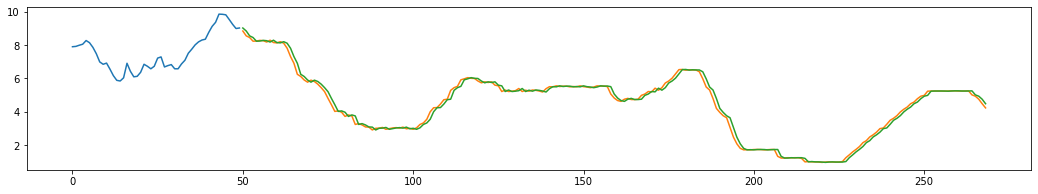

In [105]:
# plot predictions and expected results on the test data
plt.plot(train_y[-50:])
plt.plot([None for i in train_y[-50:]] + [x for x in test_y])
plt.plot([None for i in train_y[-50:]] + [x for x in predictions])

In [106]:
# calculate residuals from the above persistence model
residuals = [test_y[i]-predictions[i] for i in range(len(predictions))]
residuals = pd.DataFrame(residuals)

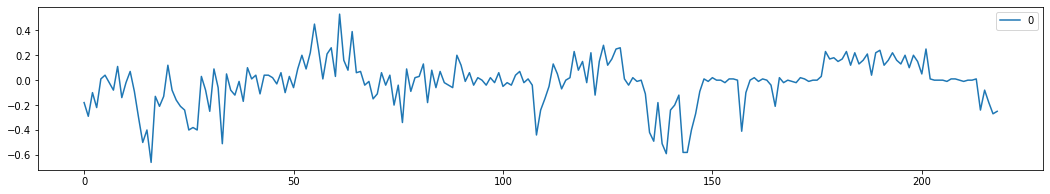

In [107]:
# plot residuals
residuals.plot()

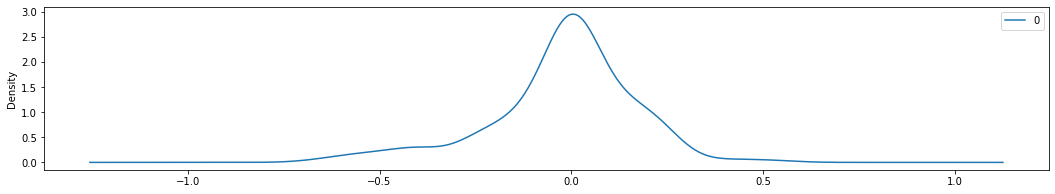

In [108]:
# density plot
residuals.plot(kind='kde')

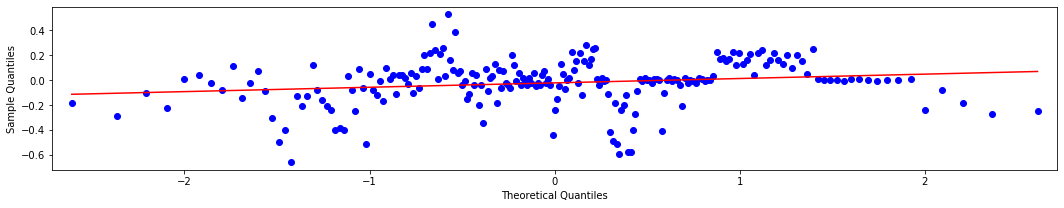

In [109]:
qqplot(residuals, line='r')
plt.show()

In [112]:
#Classification
# Create lagged dataset
values = pd.DataFrame(s.values)
df1 = pd.concat([values.shift(1), values], axis=1)
df1.columns = ['t', 't+1']

In [113]:
def make_discrete(row):
    if row['t+1'] < 0:
        return 'low'
    elif row['t+1'] > 3:
        return 'high'
    else:
        return 'medium'

In [116]:
# apply the above function to reassign t+1 values
df1['t+1'] = df1.apply(lambda row: make_discrete(row), axis=1)

In [117]:
# Randomly sample 10 elements from the dataframe
df.sample(n=10)

,FEDFUNDS
DATE,
1969-07-01,8.61
1959-12-01,3.99
1978-05-01,7.36
1998-01-01,5.56
1989-04-01,9.84
2001-01-01,5.98
1995-10-01,5.76
2000-09-01,6.52
1979-12-01,13.78


In [118]:
# create lagged dataset
values = pd.DataFrame(s.values)
df1 = pd.concat([values.shift(1), values, values.shift(-1), values.shift(-2)], axis=1)
df1.columns = ['t', 't+1', 't+2', 't+3']

In [119]:
# Forecasting
# split dataset
X = s.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]

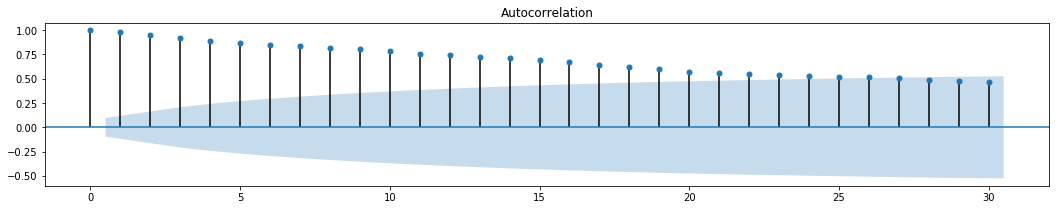

In [120]:
plot_acf(train, lags=30)
plt.show()

In [121]:
# train autoregression
model = AR(train)
model_fit = model.fit()

In [122]:
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)

Lag: 17
Coefficients: [ 0.14699951  1.38968757 -0.51929215  0.11348105 -0.10155692  0.09510047
  0.02969032 -0.21248933  0.32012915  0.0138636  -0.19166085 -0.02622292
 -0.00519709  0.24062683 -0.16726297  0.04345349  0.04757866 -0.09105107]


In [123]:
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

In [124]:
test_period = 7
for i in range(test_period):
    print('predicted=%f, expected=%f' % (predictions[i], test[i]))

rmse = np.sqrt(mean_squared_error(test[:test_period], predictions[:test_period]))

predicted=9.087625, expected=8.840000
predicted=9.202730, expected=8.550000
predicted=9.264843, expected=8.450000
predicted=9.291270, expected=8.230000
predicted=9.265821, expected=8.240000
predicted=9.186995, expected=8.280000
predicted=9.172751, expected=8.260000


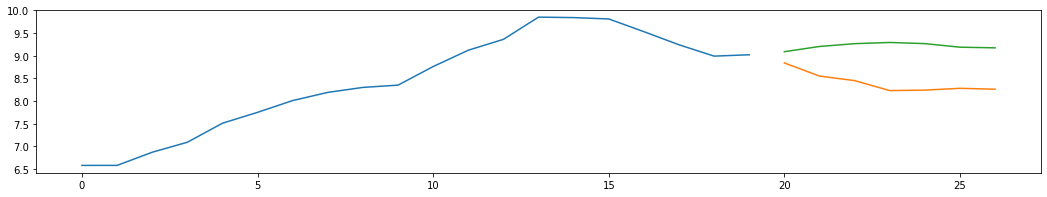

In [125]:
# plot predictions and expected results on the test data
plt.plot(train_y[-20:])
plt.plot([None for i in train_y[-20:]] + [x for x in test_y[:test_period]])
plt.plot([None for i in train_y[-20:]] + [x for x in predictions[:test_period]])

In [126]:
# Validation
# split dataset
X = s.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]

In [127]:
# train autoregression
model = AR(train)
model_fit = model.fit()
window = model_fit.k_ar
coef = model_fit.params

In [128]:


# walk forward over time steps in test
history = train[len(train)-window:]
history = [history[i] for i in range(len(history))]
predictions = []
for t in range(len(test)):
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    yhat = coef[0]
    for d in range(window):
        yhat += coef[d+1] * lag[window-d-1]
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
rmse = np.sqrt(mean_squared_error(test, predictions))

In [129]:
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.180


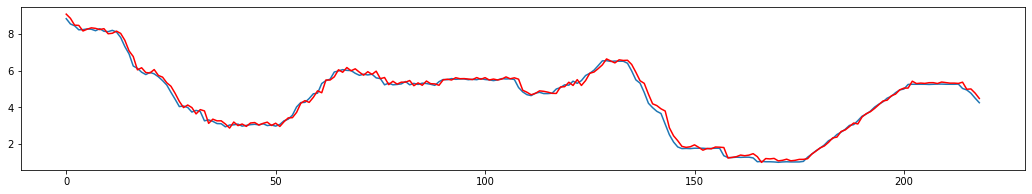

In [130]:
# plot
plt.plot(test)
plt.plot(predictions, color='red')

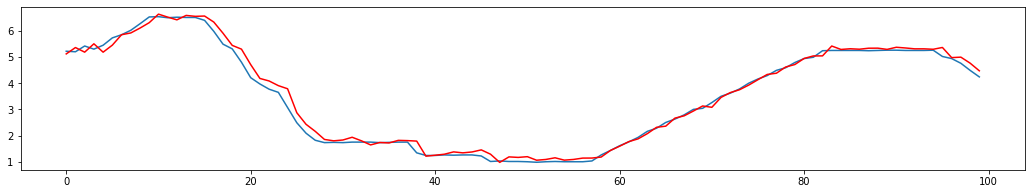

In [131]:
# zoom plot
plt.plot(test[-100:])
plt.plot(predictions[-100:], color='red')
plt.show()